In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import rotate

import cv2
import time
import math
import sys
import csv
import geopy
import geopy.distance

sys.path.append("./protos")

import grpc
import messaging_pb2
import messaging_pb2_grpc

class ImageProcessingLayer:
    def __init__(
        self,
        output_dim=(1000, 1000),
        mock=True,
        mock_image_path=None,
        mock_num_samples=10,
        mock_wait_time=1,
        mock_corner_gps_coords=None,
    ):
        self.mock = mock

        if not mock:
            return

        self.mock_wait_time = mock_wait_time

        if mock_image_path is None:
            # mock_image_path = "data/demo.jpg"
            mock_image_path = "../data/demo.jpg"

        self._mock_img_full = np.asarray(Image.open(mock_image_path))[:, :, :3]

        self._output_dim = output_dim
        diag_len = np.sqrt(self._output_dim[0] ** 2 + self._output_dim[1] ** 2)
        self._gcps_pixels = self._generate_random_gcps(
            self._mock_img_full, mock_num_samples, padding=(diag_len, diag_len)
        )

        self._mock_corner_gps_coords = mock_corner_gps_coords
        self._pixel_to_gps_transform = self._dataset_pixel_to_gps_transform(
            self._mock_corner_gps_coords
        )

        self._path_pixels = self._build_path_pixels(self._gcps_pixels)

    def _generate_random_gcps(self, img, num_samples, padding=(0, 0)):
        return np.random.randint(
            padding,
            high=(
                img.shape[1] - padding[0] - 10,
                img.shape[0] - padding[1] - 10,
            ),
            size=(num_samples, 2),
        )

    def _build_path_pixels(self, gcps):
        STEP_SIZE = 400

        delta = np.diff(gcps, axis=0)
        directions = delta / np.linalg.norm(delta, axis=1).reshape(-1, 1)
        angles = -np.arctan2(directions.T[1], directions.T[0]) * 180 / np.pi
        delta_angles = np.append(np.diff(angles), 0)

        path = []

        for t1, t2, angle, delta_angle in zip(gcps, gcps[1:], angles, delta_angles):
            steps = np.linalg.norm(t2 - t1) / STEP_SIZE
            line = np.linspace(t1, t2, steps.astype("uint32"), dtype="uint32")
            path.extend([np.array([x, y, angle]) for x, y in line])

            if delta_angle == 0:
                continue

            if len(line) == 0:
                continue

            interpolated_angles = np.linspace(angle, angle + delta_angle, 3)
            path.extend(
                [
                    np.array([line[-1][0], line[-1][1], theta])
                    for theta in interpolated_angles
                ]
            )

        return path

    def _next_image(self):
        if self.mock_wait_time > 0:
            time.sleep(self.mock_wait_time)

        sample_diag = np.sqrt(self._output_dim[0] ** 2 + self._output_dim[1] ** 2)

        for x, y, theta in self._path_pixels:
            sample = self._crop_around(
                self._mock_img_full, (y, x), (sample_diag, sample_diag)
            )
            
            rotated_img = self._center_crop(
                rotate(sample, -theta, reshape=False), self._output_dim
            )
            
            theta_radians = theta / 180 * math.pi

            center = np.array((x, y))

            corner_gps_coords = self._get_corner_gps_coords_of_sample_img(
                center, theta_radians
            )
            yield rotated_img, corner_gps_coords

    def _crop_around(self, img, center, dim):
        dim = np.array(dim).astype("uint32")
        x = int(center[1] - dim[1] // 2)
        y = int(center[0] - dim[0] // 2)
        return img[y : y + dim[0], x : x + dim[1]]

    def _center_crop(self, img, dim):
        return img[
            img.shape[0] // 2 - dim[0] // 2 : img.shape[0] // 2 + dim[0] // 2,
            img.shape[1] // 2 - dim[1] // 2 : img.shape[1] // 2 + dim[1] // 2,
        ]

    def _rotate_vec2d(self, vec2d, radians):
        """Only rotate a point around the origin (0, 0)."""
        x, y = vec2d
        x_new = x * math.cos(radians) - y * math.sin(radians)
        y_new = x * math.sin(radians) + y * math.cos(radians)

        return np.array([x_new, y_new])

    def _rotate_pixel_about_center(self, xy, center, radians):
        vector_from_center = np.array(xy) - np.array(center)
        return self._rotate_vec2d(vector_from_center, -radians)

    def _sample_pixel_to_dataset_pixel_coords(self, xy, sample_center, radians):
        # Sample pixel coordinate system has (0,0) at the top left of the sample image
        sample_center_in_sample_pixel_coords = (
            np.array((self._output_dim[1], self._output_dim[0])) / 2
        )
        rotated_coords = self._rotate_pixel_about_center(
            xy, sample_center_in_sample_pixel_coords, radians
        )
        return rotated_coords + sample_center

    def _sample_pixel_to_gps_coords(self, xy, sample_center, radians):
        """
        sample_center is the center coordinates (np array) of the sample image in the dataset pixel coordinate system
        """
        dataset_pixel_coords = self._sample_pixel_to_dataset_pixel_coords(
            xy, sample_center, radians
        )
        return self._pixel_to_gps_transform(dataset_pixel_coords)

    def _get_corner_gps_coords_of_sample_img(self, center, radians):
        """
        center is the center coordinates (np array) of the sample image in the dataset pixel coordinate system
        radians is the angle that the sample image coordinate system is rotated relative to the dataset
            coordinate system (CCW)
        sample_dim is (height, width)
        """

        height, width = self._output_dim

        top_left_pixel = np.array((0, 0))
        top_right_pixel = np.array((width, 0))
        bot_left_pixel = np.array((0, height))
        bot_right_pixel = np.array((width, height))

        return [
            self._sample_pixel_to_gps_coords(corner_pixel, center, radians)
            for corner_pixel in [
                top_left_pixel,
                top_right_pixel,
                bot_left_pixel,
                bot_right_pixel,
            ]
        ]

    def _dataset_pixel_to_gps_transform(self, corner_gps_coords):
        height, width = self._mock_img_full.shape[:2]
        top_left_gps, top_right_gps, bot_left_gps, bot_right_gps = corner_gps_coords
        right_vec = (top_right_gps - top_left_gps) / width
        bot_vec = (bot_left_gps - top_left_gps) / height

        transformation = np.array(
            [[right_vec[0], bot_vec[0]], [right_vec[1], bot_vec[1]]]
        )

        def transform(pixel):
            return transformation @ pixel + top_left_gps

        return transform

    def run(self, img=None):
        if not self.mock:
            assert img is not None, "Image cannot be None"
            return img

        return self._next_image()


class ObjectDetectionLayer:
    def __init__(
        self, weights_file=None, classes_file=None, config_file=None, min_confidence=0.3
    ):
        self.weights_file = weights_file
        self.config_file = config_file
        self.classes_file = classes_file

        self.net = self._load_model()
        self.min_confidence = min_confidence

        self.classes = ["car", "truck", "bus", "minibus", "cyclist"]

    def _load_model(self):
        return cv2.dnn.readNet(self.weights_file, self.config_file)

    def _get_output_layers(self, net):
        layer_names = net.getLayerNames()
        try:
            output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
        except:
            output_layers = [
                layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()
            ]

        return output_layers

    def _get_bboxes_pixels(self, img):
        image = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        Height, Width = image.shape[:2]
        scale = 0.00392

        blob = cv2.dnn.blobFromImage(
            image, scale, (416, 416), (0, 0, 0), True, crop=False
        )

        self.net.setInput(blob)

        outs = self.net.forward(self._get_output_layers(self.net))

        class_ids = []
        confidences = []
        boxes = []
        conf_threshold = 0.5
        nms_threshold = 0.4

        for out in outs:
            for detection in out:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if confidence > self.min_confidence:
                    center_x = int(detection[0] * Width)
                    center_y = int(detection[1] * Height)
                    w = int(detection[2] * Width)
                    h = int(detection[3] * Height)
                    x = center_x - w / 2
                    y = center_y - h / 2
                    class_ids.append(class_id)
                    confidences.append(float(confidence))
                    boxes.append([x, y, w, h])

        indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

        bboxes_with_confidence = []
        for i in indices:
            try:
                box = boxes[i]
            except Exception:
                box = boxes[i[0]]

            x, y, w, h = [max(v, 0) for v in box[:4]]  # model outputs can be negative

            bboxes_with_confidence.append(
                np.array((x, x + w, y, y + h, 100 * confidences[i]))
            )

        # follows the format of x0, x1, y0, y1, confidence
        return np.array(bboxes_with_confidence).astype(int)

    def _bbox_pixels_to_gps(self, bboxes, gps_corners, img_dim):
        top_left_gps, top_right_gps, bot_left_gps, bot_right_gps = gps_corners
        right_vec = (top_right_gps - top_left_gps) / img_dim[1]
        bot_vec = (bot_left_gps - top_left_gps) / img_dim[0]

        transformation = np.array(
            [[right_vec[0], bot_vec[0]], [right_vec[1], bot_vec[1]]]
        )

        def transform(bbox):
            return transformation @ bbox + top_left_gps

        return np.array([(*transform(bbox[:2]), *bbox[2:4]) for bbox in bboxes])

    # Be careful using this radius. Pixel distance does not convert to latitude and longitude in the same way
    def _convert_bbox_to_radial_representation(self, bboxes):
        """
        Given a bbox in the format of x0, x1, y0, y1, confidence.
        Returns a bbox in the format of x, y, r, confidence
        """

        # TODO: Scale by some factor (function of altitude) to convert pixels to meters
        dx = bboxes[:, 1] - bboxes[:, 0]
        dy = bboxes[:, 3] - bboxes[:, 2]
        radii = np.sqrt(dx**2 + dy**2) / 2

        return np.array(
            [
                (bboxes[:, 0] + bboxes[:, 1]) / 2,
                (bboxes[:, 2] + bboxes[:, 3]) / 2,
                radii,
                bboxes[:, 4],
            ]
        ).T
        
    #get heading of the image from the corner gps points
    def _get_heading(self, top_left_gps, bot_left_gps):
        dLon = top_left_gps[1] - bot_left_gps[1];
        y = math.sin(dLon) * math.cos(top_left_gps[0]);
        x = math.cos(bot_left_gps[0])*math.sin(top_left_gps[1]) - math.sin(bot_left_gps[1])*math.cos(top_left_gps[1])*math.cos(dLon);
        brng = np.rad2deg(math.atan2(y, x));
        if brng < 0: brng+= 360
        return brng

    def run(self, img, gps_sample_corners):
        bboxes_pixels = self._get_bboxes_pixels(img)

        if len(bboxes_pixels) == 0:
            return [], [], []

        # bboxes_radial_pixels = self._convert_bbox_to_radial_representation(
        #     bboxes_pixels
        # )
        # bboxes_radial_gps = self._bbox_pixels_to_gps(
        #     bboxes_radial_pixels, gps_sample_corners, img.shape
        # )

        #return bboxes_radial_gps, bboxes_pixels  # remove the pixels bboxes later
        top_left_gps, top_right_gps, bot_left_gps, bot_right_gps = gps_sample_corners
        center_gps = (top_left_gps + top_right_gps + bot_left_gps + bot_right_gps) / 4
        
        heading = self._get_heading(top_left_gps, bot_left_gps)

        return bboxes_pixels, center_gps, heading


class GPSTranslocationLayer:
    latitude = None
    longitude = None
    altitude = None
    heading = None

    half_image_width_meters = None
    half_image_height_meters = None

    top_left = None
    top_right = None
    bottom_left = None
    bottom_right = None

    image_width = None
    image_height = None

    def _load_mocked_metadata(self, center_coordinates, corners, heading):
        self.image_width = 1000
        self.image_height = 1000

        self.latitude = center_coordinates[0]
        self.longitude = center_coordinates[1]
        
        self.heading =  heading
        
        self.top_left = corners[0]
        self.top_right = corners[1]
        self.bottom_left = corners[2]
        self.bottom_right = corners[3]
        
        h_dist = geopy.distance.distance((corners[0][0], corners[0][1]), (corners[1][0], corners[1][1])).m
        v_dist = geopy.distance.distance((corners[0][0], corners[0][1]), (corners[3][0], corners[3][1])).m
        
        self.half_image_height_meters = v_dist / 2
        self.half_image_width_meters = h_dist / 2
        

    # def _load_metadata(self, image_path):
    #     with exiftool.ExifToolHelper() as et:
    #         metadata = et.get_metadata(image_path)[0]

    #     self.image_width = (
    #         dict.get(metadata, "EXIF:ExifImageWidth", None)
    #         or dict.get(metadata, "EXIF:ImageWidth", None)
    #         or dict.get(metadata, "File:ImageWidth")
    #     )
    #     self.image_height = (
    #         dict.get(metadata, "EXIF:ExifImageHeight", None)
    #         or dict.get(metadata, "EXIF:ImageHeight", None)
    #         or dict.get(metadata, "File:ImageHeight")
    #     )

    #     self.latitude = metadata["EXIF:GPSLatitude"]
    #     self.longitude = metadata["EXIF:GPSLongitude"]
    #     self.altitude = metadata["EXIF:GPSAltitude"]
    #     self.heading = dict.get(metadata, "EXIF:GPSImgDirection", 0)

    #     if self.heading == 0:
    #         print(
    #             "WARNING: Heading defaulted to 0. The program will continute to run, but this may cause issues."
    #         )

    #     if metadata["EXIF:GPSLatitudeRef"] == "S":
    #         assert self.latitude >= 0, "Latitude is negative but ref is S"
    #         self.latitude *= -1

    #     if metadata["EXIF:GPSLongitudeRef"] == "W":
    #         assert self.longitude >= 0, "Longitude is negative but ref is W"
    #         self.longitude *= -1

    #     if metadata["EXIF:GPSImgDirectionRef"] == "M":
    #         assert (
    #             np.abs(self.heading) > 2 * np.pi
    #         ), "Heading is in radians but we assume degrees. Please fix"
    #         self.heading -= 8.0  # subtract 8deg to account for magnetic declination

    #     units_to_meter_conversion_factors = [
    #         None,  # this is the default value
    #         0.0254,  # inches
    #         1e-2,  # cm
    #         1e-3,  # mm
    #         1e-6,  # um
    #     ]
    #     unit_index = dict.get(metadata, "EXIF:FocalPlaneResolutionUnit", 1) - 1
    #     resolution_conversion_factor = units_to_meter_conversion_factors[unit_index]

    #     assert (
    #         resolution_conversion_factor is not None
    #     ), "FocalPlaneResolutionUnit is None"

    #     focal_length = metadata["EXIF:FocalLength"] * resolution_conversion_factor
    #     sensor_width = (
    #         metadata["EXIF:FocalPlaneXResolution"] * resolution_conversion_factor
    #     )
    #     sensor_height = (
    #         metadata["EXIF:FocalPlaneYResolution"] * resolution_conversion_factor
    #     )

    #     self.half_image_width_meters = self.altitude * sensor_width / focal_length
    #     self.half_image_height_meters = self.altitude * sensor_height / focal_length
    #     # self.half_image_width_meters = 23.8107
    #     # self.half_image_height_meters = 17.5875

    def _destination_point(self, start_lat, start_lon, bearing, distance):
        start_point = geopy.Point(start_lat, start_lon)
        distance = geopy.distance.distance(meters=distance)
        destination_point = distance.destination(point=start_point, bearing=bearing)
        return destination_point.latitude, destination_point.longitude

    def _get_corner_coordinates(self):
        # Calculate the distances to the corners
        distance_to_corner = np.sqrt(
            (self.half_image_width_meters) ** 2 + (self.half_image_height_meters) ** 2
        )

        # Calculate the bearings from the center to the corners
        bearing_top_right = (
            self.heading
            - 180
            + np.degrees(
                np.arctan2(self.half_image_height_meters, self.half_image_width_meters)
            )
        ) % 360
        bearing_top_left = (
            self.heading
            - 180
            + np.degrees(
                np.arctan2(self.half_image_height_meters, -self.half_image_width_meters)
            )
        ) % 360
        bearing_bottom_right = (
            self.heading
            - 180
            + np.degrees(
                np.arctan2(-self.half_image_height_meters, self.half_image_width_meters)
            )
        ) % 360
        bearing_bottom_left = (
            self.heading
            - 180
            + np.degrees(
                np.arctan2(
                    -self.half_image_height_meters, -self.half_image_width_meters
                )
            )
        ) % 360

        # Calculate the GPS coordinates of the corners
        self.top_right = self._destination_point(
            self.latitude, self.longitude, bearing_top_right, distance_to_corner
        )
        self.top_left = self._destination_point(
            self.latitude, self.longitude, bearing_top_left, distance_to_corner
        )
        self.bottom_right = self._destination_point(
            self.latitude, self.longitude, bearing_bottom_right, distance_to_corner
        )
        self.bottom_left = self._destination_point(
            self.latitude, self.longitude, bearing_bottom_left, distance_to_corner
        )

    def _pixel_to_gps(self, pixel):
        x, y = pixel

        center_relative_position_pixel = (x - self.image_width, y - self.image_height)

        pixel_heading = (
            self.heading
            + np.degrees(np.arctan2(*center_relative_position_pixel[::-1]))
            + 90  # this may be wrong :shrug:
        )

        displacement_x_meters = (
            (center_relative_position_pixel[0] / self.image_width)
            * 2
            * self.half_image_height_meters
        )
        displacement_y_meters = (
            (center_relative_position_pixel[1] / self.image_height)
            * 2
            * self.half_image_width_meters
        )

        distance_meters = np.sqrt(
            displacement_x_meters**2 + displacement_y_meters**2
        )

        return self._destination_point(
            self.latitude, self.longitude, pixel_heading, distance_meters
        )

    def _bbox_pixels_to_center_gps(self, bbox_pixels):
        y_min, y_max, x_min, x_max = bbox_pixels  # x: cols, y: rows

        bbox_center = (y_min + y_max) / 2, (x_min + x_max) / 2
        return self._pixel_to_gps(bbox_center)

    def _get_radius_of_bbox_in_meters(self, bbox_pixels):
        y_min, y_max, x_min, x_max = bbox_pixels  # x: cols, y: rows
        axis_length_pixels = (y_max - y_min) / 2, (x_max - x_min) / 2
        axis_length_meters = (
            axis_length_pixels[0]
            / self.image_height
            * 2
            * self.half_image_height_meters,
            axis_length_pixels[1] / self.image_width * 2 * self.half_image_width_meters,
        )

        return np.sqrt(axis_length_meters[0] ** 2 + axis_length_meters[1] ** 2)

    def _bbox_gps_center_and_radius_in_meters(self, bbox_pixels):
        center = self._bbox_pixels_to_center_gps(bbox_pixels)
        radius = self._get_radius_of_bbox_in_meters(bbox_pixels)
        return center[0], center[1], radius

    def run(self, bboxes, center, corners, heading):
        #self._load_metadata(image_path)
        self._load_mocked_metadata(center, corners, heading)

        return [
            (self._bbox_gps_center_and_radius_in_meters(bbox[:4]) + (bbox[4],))
            for bbox in bboxes
        ]
    

class MavlinkInterfaceLayer:
    def __init__(self, protos_path="protos"):
        self.protos_path = protos_path
        self.channel = grpc.insecure_channel("localhost:50051")
        self.stub = messaging_pb2_grpc.MessagingServiceStub(self.channel)

    def run(self, bboxes):
        if len(bboxes) == 0:
            return

        responses = []

        for bbox in bboxes:
            encoded_bbox = str(bbox)[1:-1].replace(",", "") # remove the brackets
            print(encoded_bbox)
            response = self.stub.SendData(messaging_pb2.DataRequest(data=encoded_bbox))
            responses.append(response)

        return responses

In [2]:
# lat_center = 29.643946
# lon_center = -82.355659

# lat_mile = 0.0144927536231884
# lon_mile = 0.0181818181818182
# lat_min = lat_center - (15 * lat_mile)
# lat_max = lat_center + (15 * lat_mile)
# lon_min = lon_center - (15 * lon_mile)
# lon_max = lon_center + (15 * lon_mile)

# DATASET_TOP_LEFT_GPS = np.array((lat_min, lon_min))
# DATASET_TOP_RIGHT_GPS = np.array((lat_max, lon_min))
# DATASET_BOT_LEFT_GPS = np.array((lat_min, lon_max))
# DATASET_BOT_RIGHT_GPS = np.array((lat_max, lon_max))

# DATASET_CORNER_GPS_COORDS = np.array(
#     [
#         DATASET_TOP_LEFT_GPS,
#         DATASET_TOP_RIGHT_GPS,
#         DATASET_BOT_LEFT_GPS,
#         DATASET_BOT_RIGHT_GPS,
#     ]
# )

DATASET_TOP_LEFT_GPS = np.array((12.86308254761559, 77.5151947517078))
DATASET_TOP_RIGHT_GPS = np.array((12.863010715187013, 77.52267023737696))
DATASET_BOT_LEFT_GPS = np.array((12.859008245256549, 77.5151541499705))
DATASET_BOT_RIGHT_GPS = np.array((12.858936436333265, 77.52262951527761))
DATASET_CORNER_GPS_COORDS = np.array([DATASET_TOP_LEFT_GPS, DATASET_TOP_RIGHT_GPS, DATASET_BOT_LEFT_GPS, DATASET_BOT_RIGHT_GPS])

### Make sure to run `realtime_ui/network.py` on the side first

/Users/sahajpatel/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py:3011: DecompressionBombWarning: Image size (111695860 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


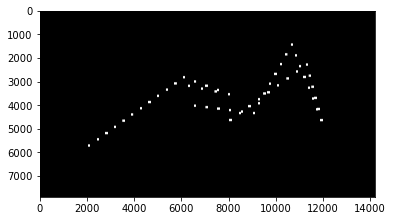

<ipython-input-3-59bb5d7fba3f>:34: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if bboxes_pixels == []: #no detections found


BBOXES:  [[651 679 430 471  99]
 [569 635 440 527  87]
 [735 767 597 658  59]]
12.861921211447639 77.51819430219491 1.6309249092057 99


_InactiveRpcError: <_InactiveRpcError of RPC that terminated with:
	status = StatusCode.UNAVAILABLE
	details = "failed to connect to all addresses"
	debug_error_string = "{"created":"@1681661524.137576000","description":"Failed to pick subchannel","file":"src/core/ext/filters/client_channel/client_channel.cc","file_line":3129,"referenced_errors":[{"created":"@1681661524.137576000","description":"failed to connect to all addresses","file":"src/core/lib/transport/error_utils.cc","file_line":163,"grpc_status":14}]}"
>

In [3]:
# np.random.seed(40)

mock_image_path = "../data/Copy of Blore_Clean.tif"

img_layer = ImageProcessingLayer(
    mock_wait_time=1,
    mock_corner_gps_coords=DATASET_CORNER_GPS_COORDS,
    mock_image_path=mock_image_path,
)

# For illustration, show the mock path
pathtrace = np.zeros(img_layer._mock_img_full.shape[:2])
for pixel in img_layer._path_pixels:
    y, x = pixel[:2].astype(int)
    pathtrace[x-50:x+50, y-50:y+50] = 1
plt.imshow(pathtrace, cmap="gray")
plt.show()

weights_file = "../yolo/yolov3-aerial.weights"
classes_file = "../yolo/aerial.names"
config_file = "../yolo/yolov3-aerial.cfg"

obj_layer = ObjectDetectionLayer(
    config_file=config_file, weights_file=weights_file, classes_file=classes_file
)

gps_layer = GPSTranslocationLayer()

mav_layer = MavlinkInterfaceLayer()

for img, img_corner_gps in img_layer.run():
    bboxes_pixels, coords, heading = obj_layer.run(img, img_corner_gps)

    if bboxes_pixels == []: #no detections found
        continue
    
    bboxes_gps = gps_layer.run(bboxes_pixels, coords, img_corner_gps, heading)

    mav_layer.run(bboxes_gps)
